# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
!pip install imbalanced-learn

In [2]:
!pip install scikit-learn==0.24.1

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import Counter
from workspace import active_session

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pylab import *

from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

with open('selected_columns.pkl', 'rb') as f:
    selected_columns = pickle.load(f)

# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', 370)
pd.set_option('display.max_rows', 500)

# FUNCTIONS

In [5]:
%%time

def read_and_standardize_attributes():
    """
    Read Attributes excel files
    
    return:
    attributes: attributes data in pandas format
    attributes_info: attributes information levels file data in pandas format
    """
    attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', header=1, index_col=None)
    attributes_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', header=1, index_col=None)
    
    attributes= attributes.reset_index().drop(columns=['index'], axis=1)
    attributes_info = attributes_info.reset_index().drop(columns=['index'], axis=1)
    
    return attributes, attributes_info

def fix_warning_cols(df):
    """
    Function to replace 'X', 'XX' and 'nan' values with -1 in 
    columns 18 and 19 i.e. ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'] 
    
    """
    cols = ["CAMEO_DEUG_2015", "CAMEO_INTL_2015", 'CAMEO_DEU_2015']
    
    df[cols] = df[cols].replace({"X": np.nan, "XX": np.nan})
    
    try:
        df[cols] = df[cols].astype(float)
    except:
        pass
        
    for column in cols:
        
        values = df[column].unique()
        
        for value in values:
            
            try:
                item = float(value)
                df[cols] = df[cols].replace({value: item})
                
            except:
                pass
            
    return df

def standardize_dataset(df):
    """
    Search for data matching attributes file data and convert unknown to -1
    and data without unknown categorie convert to NaN
    
    input:
    df - pandas dataframe
    output:
    df - standardized with attributes file values
    """
    
    try:
        with open('attributes.pkl', 'rb') as f:
            attributes = pickle.load(f)
    except:
        pass
    
    
    df["TITEL_KZ"] = df["TITEL_KZ"].replace(0, np.nan)
    df["TITEL_KZ"] = df["TITEL_KZ"].replace(-1, np.nan)
    
    # List of Attributes with 'unknown' values expected
    columns_with_unknown = attributes[attributes['Meaning'].str.contains('known') & (attributes['Value'] == -1)]['Attribute'].unique()

    # List of attributes without 'unknown' values and not numerical values
    without_unknown_or_numeric_attributes = attributes[(~attributes['Attribute'].isin(columns_with_unknown)) 
                                                       & (~attributes['Meaning'].str.contains('numeric'))]['Attribute'].unique().tolist()

    # List of numeric attributes
    numeric_attributes = attributes[(attributes['Meaning'].str.contains('numeric')) 
                                    & (~attributes['Attribute'].isin(columns_with_unknown))]['Attribute'].unique().tolist()
    
    for column in columns_with_unknown:

        attribute_values = attributes[attributes['Attribute'] == column]['Value'].tolist()
        dataframe_column_values = df[column].unique().tolist()

        if not all(item in attribute_values for item in dataframe_column_values):
            not_matches_list = [attribute for attribute in dataframe_column_values if attribute not in attribute_values]
            #print(not_matches_list)
            for not_match in not_matches_list:
                df[column] = df[column].replace(not_match, -1)

    for column in without_unknown_or_numeric_attributes:

        attribute_values_2 = attributes[attributes['Attribute'] == column]['Value'].tolist()
        dataframe_column_values_2 = df[column].unique().tolist()

        if not all(item in attribute_values_2 for item in dataframe_column_values_2):
            not_matches_list = [attribute for attribute in dataframe_column_values_2 if attribute not in attribute_values_2]
            #print(not_matches_list)
            for not_match in not_matches_list:
                df[column] = df[column].replace(not_match, np.nan)
                
                
    return df


def common_attributes_fc(azdias_df, customers_df, attributes_df):
    """
    This function takes common attributes in azdias, customers and attributes files.
    """
    try:
        with open('common_attributesr.pkl', 'rb') as f:
            common_attributes = pickle.load(f)
    except:
        azdias_att = list(azdias_df.columns)
        customers_att = list(customers_df.columns)

        attributes_att  = attributes_df['Attribute'].unique().tolist()

        common_attributes = list(set(attributes_att) & set(azdias_att) & set(customers_att))
        
    return common_attributes


def data_full_adjustment(df):
    """
    Fixing and cleaning Data this is set to any of four datasets
    """

    with open('common_attributesr.pkl', 'rb') as f:
        common_attributes = pickle.load(f)
        
    with open('selected_columns.pkl', 'rb') as f:
        selected_columns.pkl = pickle.load(f)

    with open('attributes.pkl', 'rb') as f:
            attributes = pickle.load(f)
    new_df = df.copy()
    
    new_df = fix_warning_cols(new_df)
    print("Fixed Warning Columns")
    new_df = new_df[common_attributes]
    print("Setting only common attributes: OK!")
    new_df = standardize_dataset(new_df)
    print("Standardize Dataset Values: OK!")
    new_df = feature_engeneering(new_df)
    print("Feature Engeneering: OK!")
    new_df = label_categorical_to_numeric(new_df)
    new_df = replace_unknown_values(new_df)
    new_df = new_df[selected_columns]
    
    return new_df   

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.4 µs


# Feature Functions
Some features are just a translation to make it easier and others are feature engeneering

In [6]:
%%time
def wealth_feature(df):
    """
    Create 'wealth' feature derived from 'CAMEO_INTL_2015'
    """
    
    wealth_dict = {-1:'unknown',1:'wealthy',2:'prosperous',
                   3:'comfortable',4:'less-affluent',5:'poorer'}
    
    
    df['wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor_divide(float(x), 10) if float(x) else -1)
    df['wealth'] = df['wealth'].map(wealth_dict)
    
    return df

def family_feature(df):
    """
    Create 'family' feature derived from 'CAMEO_INTL_2015'
    """
    
    family_dict = {-1:'unknown',1:'Pre-Family Couples & Singles',
                   2:'Young Couples With Children',
                   3:'Families With School Age Children',
                   4:'Older Families &  Mature Couples',
                   5:'Elders In Retirement'}
    
    df['family'] = df['CAMEO_INTL_2015'].apply(lambda x: np.mod(float(x), 10) if float(x) else -1)
    #df['family'] = df['family'].replace(np.nan,-1)
    df['family'] = df['family'].map(family_dict)
    df['family'] = df['family'].fillna('unknown')
    
    return df

def neighborhood_feature(df):
    """
    Create 'neighborhood_quality' feature derived from 'WOHNLAGE'
    """
    neigh_dict = {-1: 'unknown', 
                  0: 'unknown', 1:'very_good', 2:'good', 3:'average', 
                  4:'poor', 5: 'very_poor', 7:'rural', 8:'new_rural'}
    
    df['neighborhood_quality'] = df['WOHNLAGE'].map(neigh_dict)
    
    return df

def community_unployement_feature(df):
    """
    Create 'community_unployement' feature derived from 'RELAT_AB'
    """
    
    unployement_dict = {-1: 'unknown', 
                         1:'very_low', 2:'low', 3:'average', 4:'high', 5: 'very_high'}
    
    df['community_unployement'] = df['RELAT_AB'].map(unployement_dict)
    
    return df

def gender_feature(df):
    """
    Create 'gender' feature derived from 'ANREDE_KZ'
    """
    
    
    gender_dict = {-1: 'unknown', 1:'male', 2:'female'}
    
    df['gender'] = df['ANREDE_KZ'].map(gender_dict)

    
    
    return df


def life_stage_feature(df):
    """
    Create 'life_stage' feature derived from 'LP_LEBENSPHASE_FEIN'
    and group it by age
    """
    
    life_dict = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    
    df['life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(life_dict)
    
    return df
    
    
    
def income_feature(df):
    """
    Create 'income_category' feature derived from 'LP_LEBENSPHASE_FEIN'
    and group it by income
    """
    income_dict = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average', 27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average', 37: 'average', 38: 'average', 39: 'top', 40: 'top'}
    
    df['income_category'] = df['LP_LEBENSPHASE_FEIN'].map(income_dict)
    
    return df


def positioning_feature(df):
    """
    Create 'positioning' feature derived from 'PRAEGENDE_JUGENDJAHRE'
    and group it by something like social positioning
    """
    positioning_dict = {1: 'mainstream',  
                     3: 'mainstream',
                     5: 'mainstream',
                     8: 'mainstream',
                     10: 'mainstream',
                     12: 'mainstream',
                     14: 'mainstream',
                     #################
                     2: 'avantgarde',
                     4: 'avantgarde',
                     6: 'avantgarde', 
                     7: 'avantgarde',
                     9: 'avantgarde',
                     11: 'avantgarde',
                     13: 'avantgarde',
                     15: 'avantgarde',
                     ##################
                     -1: 'unknown'}
    
    df['positioning'] = df['PRAEGENDE_JUGENDJAHRE'].map(positioning_dict)
    
    return df

def feature_engeneering(df):
    """
    Group all features function to transform a dataframe
    """
    
    columns_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015','LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN', 'RELAT_AB']
    
    df = wealth_feature(df)
    print("Wealth Feature, ok!")
    
    df = family_feature(df)
    print("Family Feature, ok!")
    
    df = neighborhood_feature(df)
    print("Neighborhood Feature, ok!")
    
    df = community_unployement_feature(df)
    print("Community Feature, ok!")
    
    df = gender_feature(df)
    print("Gender Feature, ok!")
    
    df = life_stage_feature(df)
    print("Life Stage Feature, ok!")
    
    df = income_feature(df)
    print("Income Feature, ok!")
    
    df = positioning_feature(df)
    print("Positioning(Mainstream vs Avantgarde) Feature, ok!")
    
    birthyear_attribute = 'GEBURTSJAHR'
    df[birthyear_attribute] = df[birthyear_attribute].replace(0, np.nan)
    print("Fixing birthdate attribute - replacing zeros to NaNs")
    
    df = df.drop(columns_to_drop, axis=1)
    
    return df


def label_categorical_to_numeric(df):
    """
    Convert: 
    categorical to numeric and 
    unknown variables to NaN
    """
    
    life_stage = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
                'retirement_age': 4, 'unknown':np.nan}

    income_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4, 'unknown':np.nan}

    position_dict = {'mainstream':1, 'avantgarde':2, 'unknown':np.nan}

    neighborhood_quality = {'very_poor': 1, 'poor': 2, 'average': 3, 'good': 4, 'very_good': 5, 'new_rural': np.nan, 'rural': np.nan, 'unknown':np.nan}
    
    rural = {'very_poor': -1, 'poor': -1, 'average': -1, 'good': -1, 'very_good': -1, 'new_rural': 1, 'rural': 1, 'unknown':np.nan}
    
    community_unemployement = {'very_low': 5, 'low': 4, 'average': 3, 'high': 2, 'very_high': 1, 'unknown':np.nan}

    wealth = {'poorer': 1, 'less-affluent': 2, 'comfortable': 3, 'prosperous': 4, 'wealthy': 5, 'unknown':np.nan}

    OST_WEST = {'O': 1, 'W': 2, 'unknown':np.nan}

    gender = {'female': 1, 'male': 2, 'unknown':np.nan}

    family = {'Elders In Retirement': 5, 
              'Families With School Age Children': 4, 
              'Older Families &  Mature Couples': 3, 
              'Pre-Family Couples & Singles': 2, 
              'Young Couples With Children': 1, 
              'unknown':np.nan}

    cameo = {'1A': 1, '1B': 2, '1C': 3, '1D': 4, '1E': 5, 
             '2A': 6, '2B': 7, '2C': 8, '2D': 9, 
             '3A': 10, '3B': 11, '3C': 12, '3D': 13, 
             '4A': 14, '4B': 15, '4C': 16, '4D': 17, '4E': 18, 
             '5A': 19, '5B': 20, '5C': 21, '5D': 22, '5E': 23, '5F': 24, 
             '6A': 25, '6B': 26, '6C': 27, '6D': 28, '6E': 29, '6F': 30, 
             '7A': 31, '7B': 32, '7C': 33, '7D': 34, '7E': 35, 
             '8A': 36, '8B': 37, '8C': 38, '8D': 39, 
             '9A': 40, '9B': 41, '9C': 42, '9D': 43, '9E': 44}




    df['life_stage'] = df['life_stage'].replace(life_stage).astype(float)
    df['income_category'] = df['income_category'].replace(income_scale).astype(float)
    df['positioning'] = df['positioning'].replace(position_dict).astype(float)
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(OST_WEST).astype(float)
    df['gender'] = df['gender'].replace(gender).astype(float)
    df['wealth'] = df['wealth'].replace(wealth).astype(float)
    df['rural'] = df['neighborhood_quality'].replace(rural).astype(float)
    df['neighborhood_quality'] = df['neighborhood_quality'].replace(neighborhood_quality).astype(float)
    df['family'] = df['family'].replace(family).astype(float)
    df['community_unployement'] = df['community_unployement'].replace(community_unemployement).astype(float)
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace(cameo).astype(float)
    
    return df



def replace_unknown_values(df):
    """
    Replace all unknown values '-1' to NaN
    """
    df_columns = df.columns

    for column in df_columns:
        df[column] = df[column].replace(-1,np.nan)
        
    return df


CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 13.8 µs


### Cluster Plot

In [7]:
def plot_clusters(model, df1,df2,label1='General Population',label2="Customers"):
    """
    This function plot the population clusters in datasets
    :params:
    model: KMeans model. Fitted model for clusters
    df1, df2: Pandas DataFrame. Dataframes to compare and plot
    label1, label2: String. Strings to show in the plot
    :return:
    None
    """

    azdias_K = list(model.predict(df1))
    for i in range(len(azdias_K)):
        azdias_K[i] += 1
    customers_K =  list(model.predict(df2))
    for i in range(len(customers_K)):
        customers_K[i] += 1

    data_label = []
    for i in range(len(df1)):
        data_label.append('General Population')
    for i in range(len(df2)):
        data_label.append('Customers')

    data_clusters = azdias_K + customers_K

    data_dict = {'Data':data_label,
                 'Cluster':data_clusters}

    df_clusters = pd.DataFrame(data_dict)
    pop_data1 = list(df_clusters[df_clusters['Data']=='General Population']['Data'].values)
    customers_data1 = list(df_clusters[df_clusters['Data']=='General Population']['Cluster'].values)
    pop_data2 = list(df_clusters[df_clusters['Data']=='Customers']['Data'].values)
    customers_data2 = list(df_clusters[df_clusters['Data']=='Customers']['Cluster'].values)


    pop_dict = dict(Counter(azdias_K))
    c_dict = dict(Counter(customers_K))
    tot_pop = len(azdias_K)
    tot_customers = len(customers_K)

    azdias_k_perc = []
    customers_k_perc = []

    for i in list(set(customers_K)):
        item = pop_dict[i]
        item = round(item / tot_pop, 2)
        azdias_k_perc.append(item)

    for i in list(set(customers_K)):
        item = c_dict[i]
        item = round(item / tot_customers, 2)
        customers_k_perc.append(item)

    plt.rcParams['figure.figsize'] = [15, 7]

    labels = list(set(customers_K))

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, azdias_k_perc, width, label=label1)
    rects2 = ax.bar(x + width/2, customers_k_perc, width, label=label2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Clusters')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)
    fig.save("Image_1.png")
    fig.tight_layout()

# PCA Funcs

In [20]:
def pca_model(df, n_components):
    '''
    This function defines a model that takes in a dataframe and returns model fitted in a dataframe. 
    :param:
    df: Pandas DataFrame. Dataframe to be fitted
    n_components: Integer. Number of components to fit
    :return:
    pca: KMeans(). Fitted model
    '''
    pca = PCA(n_components, svd_solver='full')
    
    return pca.fit(df)

def scree_plots(df,dataname):
    '''
    This function takes in the transformed data using PCA and plots it in scree plots
    :params:
    df: PandasDataframe. PCA transformed data
    dataname: String. String used in the tittle
    :return None:
    
    '''
    plt.rcParams["figure.figsize"] = (20,20)
    subplot(2,1,1)

    plt.plot(np.cumsum(df.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio vs Number of Components ' + dataname)
    plt.grid(b=True)


    plot = tight_layout()
    plot = plt.show()
    savefig('PCA_feat.png',format='png',dpi=200)
    
def display_interesting_features(df, pca, dimensions,show=5):
    '''
    This function displays interesting features of the selected dimension
    :params:
    df: PandasDataFrame. Base Data
    pca: PCA model
    dimensions: Integer. Number of dimensions
    show: Integer. Number of features to show
    '''
    
    features = df.columns
    components = pca.components_
    feature_weights = dict(zip(features, components[dimensions]))
    sorted_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    print('Lowest: ')
    for feature, weight, in sorted_weights[:show]:
        print('\t{:20} {:.3f}'.format(feature, weight))
    
    print('Highest: ')
    for feature, weight in sorted_weights[show*-1:]:
        print('\t{:20} {:.3f}'.format(feature, weight))

## KMeans to Fill NaN

In [9]:
def fill_nan_with_mean(df):
    """
    Fill NaN values with the mean value of the feature
    :param:
    df: PandasDataFrame. Data to be filled
    :return:
    df: PandasDataFrame. dataframe without NaN values
    """
    for column in df.columns:
        df[column].fillna(float(df[column].mean()),inplace=True)
    
    return df

def fill_nans_kmeans(df):
    """
    Fill NaN values with the mean value of the feature in the cluster
    """
    
    with open('kmodel_fill_clusters.pkl', 'rb') as f:
        kmeans = pickle.load(f)
        
    with open('azdias_scaler.pkl', 'rb') as f:
        azdias_scaler = pickle.load(f)
        
    
    new_df = df.copy()
    new_df = fill_nan_with_mean(new_df)
    new_df = pd.DataFrame(azdias_scaler.transform(new_df))
    new_df.columns = selected_columns
    
    valid = np.isfinite(new_df.copy().values)

    azdias_K = list(kmeans.predict(new_df))
    
    new_df = np.where(valid, new_df.values, np.nan)
    new_df = pd.DataFrame(new_df)
    new_df.columns = selected_columns
    
    new_df['Cluster'] = azdias_K
    clusters = list(new_df['Cluster'].sort_values().unique())
    
    for cluster in clusters:
        for column in selected_columns:
            index = new_df.loc[new_df['Cluster']==cluster][column]
            index = index[index.isnull()].index
            mean_value = new_df[new_df['Cluster']==cluster][column].mean()
            new_df.loc[index,column] = mean_value

        print(f"Cluster nº{cluster} - OK")
    
    new_df = new_df.drop(['Cluster'], axis=1)
    
    return new_df

# Attributes

In [10]:
attributes, attributes_info = read_and_standardize_attributes()

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [15]:
%%time
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 41.7 s, sys: 1min 8s, total: 1min 49s
Wall time: 11min 35s


In [16]:
%%time
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 11.9 s, sys: 4.35 s, total: 16.2 s
Wall time: 3min 5s


In [17]:
headers_azdias = azdias.columns
headers_customers = customers.columns

In [21]:
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [32]:
attributes['Attribute'].ffill(inplace=True)
attributes['Meaning'].fillna('no description', inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


# Dealing with Warnings

Dealing with this wargnings:

"<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False."

In [18]:
print(azdias.columns[18:20])

warning_columns = list(azdias.columns[18:20])

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [24]:
cameo_columns = [attribute for attribute in attributes['Attribute'].unique() if "CAMEO" in attribute]
cameo_columns

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015']

Now we have this name problem of the attribute not matching in dataframes

In [25]:
# Attribute CAMEO_INTL_2015 is named CAMEO_DEUINTL_2015 in the attributes excel
attributes_info['Attribute'] = attributes_info['Attribute'].replace("CAMEO_DEUINTL_2015", "CAMEO_INTL_2015")
attributes['Attribute'] = attributes['Attribute'].replace("CAMEO_DEUINTL_2015", "CAMEO_INTL_2015")

Looking in to the data what values are causing the problem

In [26]:
for column in warning_columns:
    values = azdias[column].unique()
    print(f" Column: {column}\n Unique Values: {list(values)}\n\n")

 Column: CAMEO_DEUG_2015
 Unique Values: [nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7', '2', '8', '9', '6', '5', '1', 'X']


 Column: CAMEO_INTL_2015
 Unique Values: [nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0, '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14', '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX']




Apparently we have strings with letters and numbers as strings

##### Fixing Warning Columns

In [27]:
azdias = fix_warning_cols(azdias)
customers = fix_warning_cols(customers)

Taking a look if the values where handled

In [28]:
for column in warning_columns:
    values = azdias[column].unique()
    print(f" Column: {column}\n Unique Values: {list(values)}\n\n")

 Column: CAMEO_DEUG_2015
 Unique Values: [nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0]


 Column: CAMEO_INTL_2015
 Unique Values: [nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0, 41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0]




Apparently the problem in columns 18 and 19 were fixed, now we need to clean and standardize some data

## Cleaning and Standardizing

In [29]:
# Find common attributes in dataframes and saving if needs to run this multiple times
try:
    with open('common_attributesr.pkl', 'rb') as f:
        common_attributes = pickle.load(f)
except:
    common_attributes = common_attributes_fc(azdias, customers, attributes)
    with open('common_attributesr.pkl', 'wb') as f:
        pickle.dump(common_attributes, f)

It will be used only the attributes common to all datasets

In [30]:
# Setting attributes common to all
attributes = attributes[attributes['Attribute'].isin(common_attributes)]
azdias = azdias[common_attributes]
customers = customers[common_attributes]

### Unknown Values in attributes

Here we will take a look into values that have the possibilitie of 'unkown' value

In [33]:
attributes[attributes['Meaning'].str.contains('known')]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_INTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known


In [34]:
#Setting unknown value to -1
att_mask = attributes['Value'] == '-1, 9'
attributes.loc[att_mask, 'Value'] = -1
    
att_mask2 = attributes['Value'] == '-1, 0'
attributes.loc[att_mask2, 'Value'] = -1

att_mask3 = ((attributes['Value'] == 10) | (attributes['Value'] == 0)) & attributes['Meaning'].str.contains('known')
attributes.loc[att_mask3, 'Value'] = -1

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-pa

In [35]:
attributes[attributes['Meaning'].str.contains('known')]

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,-1,unknown
11,ALTER_HH,main age within the household,-1,unknown / no main age detectable
33,ANREDE_KZ,gender,-1,unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_INTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,-1,unknown
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,-1,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,-1,no transactions known


#### Standardizing Data
Making values out of the attributes values to unknown values

In [36]:
%%time
azdias = standardize_dataset(azdias)
customers = standardize_dataset(customers)

CPU times: user 3.78 s, sys: 558 ms, total: 4.34 s
Wall time: 10.9 s


Fixing Birthyear Attribute since it has a lot of zeros which is basically a NaN in this case

In [37]:
# Fix Birthyear Attribute
azdias['GEBURTSJAHR'] = azdias['GEBURTSJAHR'].replace(0,np.nan)

In [40]:
%%time
azdias_adjusted = feature_engeneering(azdias.copy())
azdias_adjusted = label_categorical_to_numeric(azdias_adjusted)
azdias_adjusted = replace_unknown_values(azdias_adjusted)

Wealth Feature, ok!
Family Feature, ok!
Neighborhood Feature, ok!
Community Feature, ok!
Gender Feature, ok!
Life Stage Feature, ok!
Income Feature, ok!
Positioning(Mainstream vs Avantgarde) Feature, ok!
Fixing birthdate attribute - replacing zeros to NaNs
CPU times: user 20.3 s, sys: 39.8 s, total: 1min
Wall time: 9min 20s


#### Feature NaNs

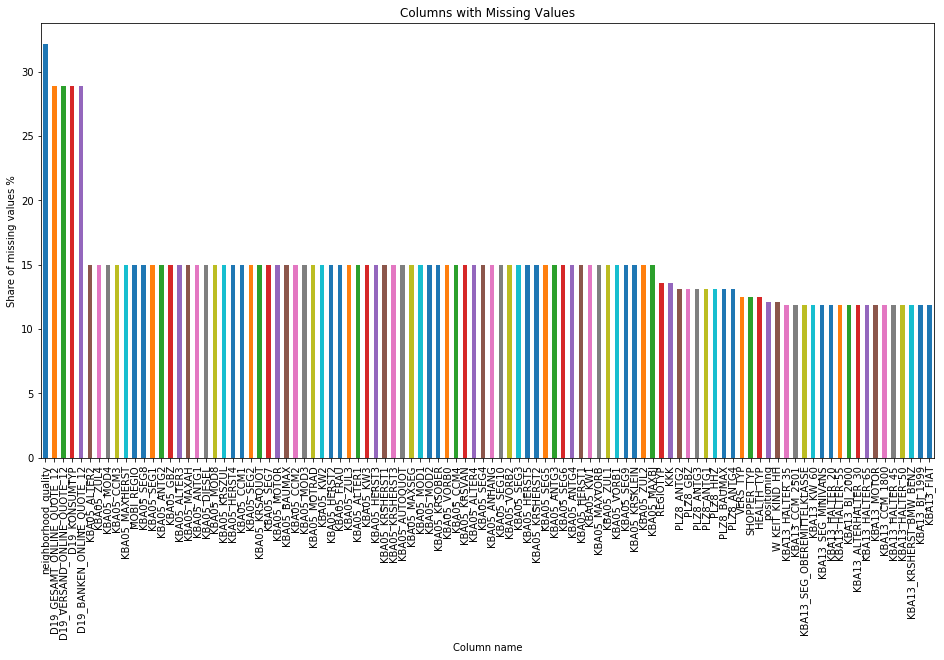

In [44]:
null_values = azdias_adjusted.isnull().sum().sort_values(ascending=False)
null_values = null_values / len(azdias_adjusted)
azdias_null_share = null_values * 100
azdias_null_share = azdias_null_share[azdias_null_share > 0]

# Plot 100 columns with highest share of missing values
fig = plt.figure()
ax = azdias_null_share.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(16,8), title=f'Columns with Missing Values')
ax.set_xlabel("Column name")
ax.set_ylabel("Share of missing values %")
ax = fig.add_subplot(ax)
fig.savefig('missingvalues.png',format='png',)

## Dropping Columns with missing values (> 35%)

In [42]:
%%time
try:
    with open('selected_columns.pkl', 'rb') as f:
        selected_columns = pickle.load(f)
except:
    selected_columns = azdias_null_share[azdias_null_share < 35].index

azdias_adjusted = azdias_adjusted[selected_columns]

CPU times: user 866 ms, sys: 8.9 s, total: 9.77 s
Wall time: 1min 55s


In [46]:
%%time
# List of Attributes with 'unknown' values expected
columns_with_unknown = attributes[attributes['Meaning'].str.contains('known') & (attributes['Value'] == -1)]['Attribute'].unique()

# List of attributes without 'unknown' values and not numerical values
without_unknown_or_numeric_attributes = attributes[(~attributes['Attribute'].isin(columns_with_unknown)) 
                                                   & (~attributes['Meaning'].str.contains('numeric'))]['Attribute'].unique().tolist()

# List of numeric attributes
numeric_attributes = attributes[(attributes['Meaning'].str.contains('numeric')) 
                                & (~attributes['Attribute'].isin(columns_with_unknown))]['Attribute'].unique().tolist()

not_numeric_attributes = [att for att in azdias_adjusted.columns if att not in numeric_attributes]

CPU times: user 35.1 ms, sys: 0 ns, total: 35.1 ms
Wall time: 597 ms


# Scalling

In [45]:
%%time
try:
    with open('azdias_scaler.pkl', 'rb') as f:
        azdias_scaler = pickle.load(f)
except:
    azdias_scaler = MinMaxScaler()
    azdias_scaler.fit(azdias_adjusted)
    with open('azdias_scaler.pkl', 'wb') as f:
        pickle.dump(azdias_scaler, f)

CPU times: user 1.5 ms, sys: 0 ns, total: 1.5 ms
Wall time: 16.1 ms


Now it will be used a MinMaxScaler to run PCA

In [49]:
%%time
azdias_columns = azdias_adjusted.columns
azdias_scaled = pd.DataFrame(azdias_scaler.transform(azdias_adjusted))
azdias_scaled.columns = azdias_columns

CPU times: user 3.46 s, sys: 17.5 s, total: 21 s
Wall time: 6min 57s


### USING PCA

In [53]:
# Fill NaN values in Columns with means for PCA
for column in azdias_columns:
    azdias_scaled[column] = azdias_scaled[column].replace(np.nan, azdias_scaled[column].mean())

In [16]:
%%time
# Fitting PCA model
with active_session():
    azdias_pca = pca_model(azdias_scaled, len(azdias_scaled.columns))

CPU times: user 4min 32s, sys: 45.5 s, total: 5min 18s
Wall time: 13min 6s


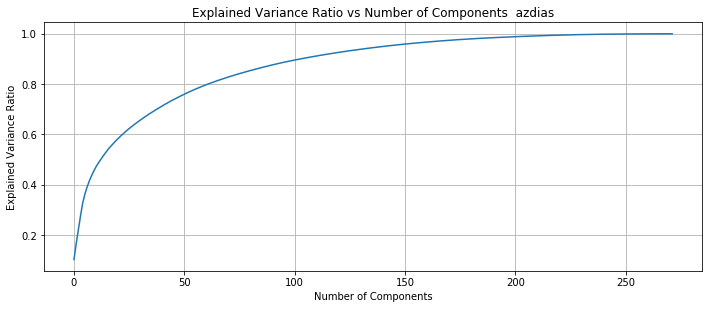

In [35]:
scree_plots(azdias_pca, ' azdias')

In the plot above we can see that 100 features explain 90% of the variance of the data

In [39]:
display_interesting_features(azdias_scaled, azdias_pca, 0,show=10)

Lowest: 
	PLZ8_ANTG4           -0.174
	PLZ8_BAUMAX          -0.170
	PLZ8_ANTG3           -0.162
	CAMEO_DEUG_2015      -0.160
	HH_EINKOMMEN_SCORE   -0.157
	FINANZ_HAUSBAUER     -0.156
	CAMEO_DEU_2015       -0.150
	EWDICHTE             -0.134
	D19_GESAMT_DATUM     -0.133
	D19_KONSUMTYP        -0.129
Highest: 
	positioning          0.136
	GREEN_AVANTGARDE     0.138
	FINANZ_MINIMALIST    0.154
	MOBI_REGIO           0.156
	KBA05_GBZ            0.162
	income_category      0.165
	KBA05_ANTG1          0.182
	wealth               0.187
	LP_STATUS_GROB       0.211
	LP_STATUS_FEIN       0.219


##### Filling NaNs with KMeans

In [ ]:
azdias_clean = fill_nans_kmeans(azdias_adjusted)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [37]:
%%time
with open('azdias_cleaned_df.pkl', 'rb') as f:
        azdias_clean= pickle.load(f)
        
with open('customers_cleaned_df.pkl', 'rb') as f:
    customers_clean = pickle.load(f)

CPU times: user 927 ms, sys: 4.99 s, total: 5.91 s
Wall time: 1min 20s


In [38]:
with open('kmodel.pkl', 'rb') as f:
    kmodel = pickle.load(f)

## Customers Clusters

CPU times: user 17.6 s, sys: 13.8 s, total: 31.4 s
Wall time: 6min 21s


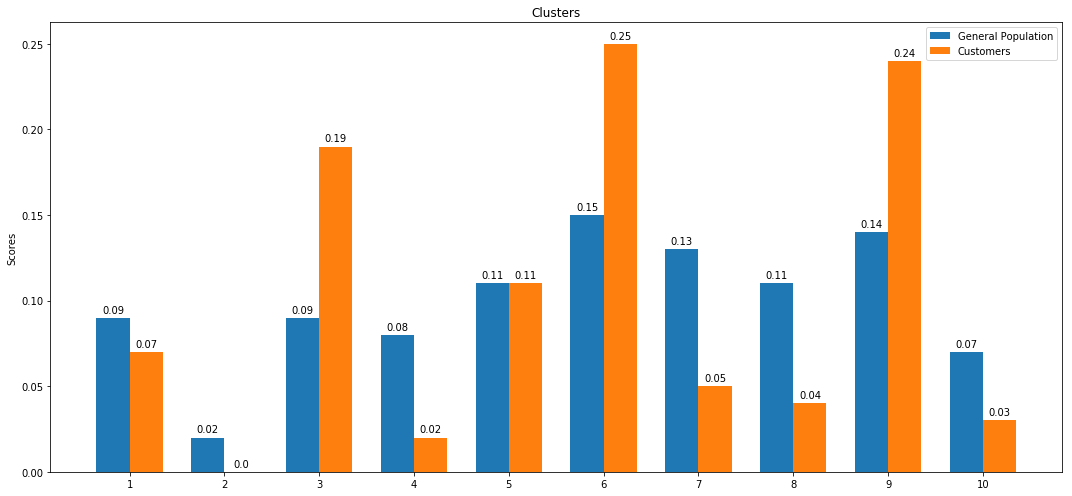

In [104]:
%%time
plot_clusters(kmodel, azdias_clean,customers_clean)

In [42]:
"""interesting_features=[positioning,GREEN_AVANTGARDE,FINANZ_MINIMALIST,
                      MOBI_REGIO,KBA05_GBZ,income_category ,KBA05_ANTG1,
                      wealth,LP_STATUS_GROB,LP_STATUS_FEIN]"""

customers_clean['Cluster'] = kmodel.predict(customers_clean)

Lets take a look in some details about the clusters

In [60]:
def show_cluster_values(df,category):
    clusters = []
    mean_value = []

    for cluster in df['Cluster'].sort_values().unique():
        value = df[df['Cluster']==cluster][category].mean()
        clusters.append(cluster+1)
        mean_value.append(value)

    data = {'Cluster': clusters,category.replace('_',' ').title():mean_value}
    data = pd.DataFrame(data).set_index('Cluster')
    data.plot(kind='bar')
    print(data)

         Income Category
Cluster                 
1               0.625618
2               0.262657
3               0.660036
4               0.265851
5               0.573048
6               0.549071
7               0.194654
8               0.157959
9               0.657131
10              0.162489


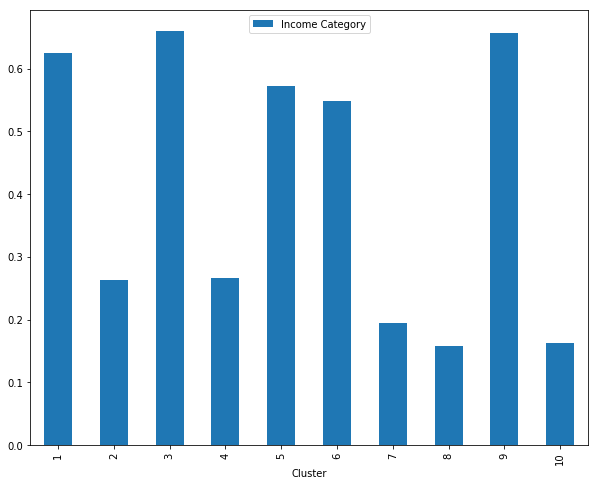

In [65]:
show_cluster_values(customers_clean,'income_category')

         Positioning
Cluster             
1           0.555285
2           0.184387
3           0.610379
4           0.086799
5           0.502826
6           0.488226
7           0.173652
8           0.096629
9           0.582985
10          0.160717


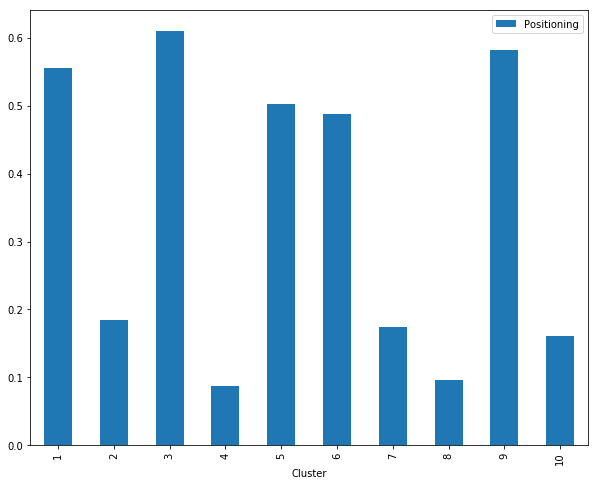

In [63]:
show_cluster_values(customers_clean,'positioning')

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [116]:
%%time
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

CPU times: user 1.55 s, sys: 108 ms, total: 1.66 s
Wall time: 1.75 s


<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


In [66]:
%%time
with active_session():
    
    with open('selected_columns.pkl', 'rb') as f:
        selected_columns = pickle.load(f)
        
        
    mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
    print(f"Dataset Loaded")
    mailout_train_LNR_RESPONSE = mailout_train[['LNR','RESPONSE']].copy()
    mailout_train_clean = mailout_train.copy()
    mailout_train_clean = data_full_adjustment(mailout_train_clean)
    
    print("Filling NaNs:")
    mailout_train_clean = fill_nans_kmeans(mailout_train_clean)

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


Dataset Loaded
Fixed Warning Columns
Setting only common attributes: OK!
Standardize Dataset Values: OK!
Wealth Feature, ok!
Family Feature, ok!
Neighborhood Feature, ok!
Community Feature, ok!
Gender Feature, ok!
Life Stage Feature, ok!
Income Feature, ok!
Positioning(Mainstream vs Avantgarde) Feature, ok!
Fixing birthdate attribute - replacing zeros to NaNs
Feature Engeneering: OK!
Filling NaNs:
Cluster nº0 - OK
Cluster nº1 - OK
Cluster nº2 - OK
Cluster nº3 - OK
Cluster nº4 - OK
Cluster nº5 - OK
Cluster nº6 - OK
Cluster nº7 - OK
Cluster nº8 - OK
Cluster nº9 - OK
Cluster nº10 - OK
Cluster nº11 - OK
Cluster nº12 - OK
Cluster nº13 - OK
Cluster nº14 - OK
Cluster nº15 - OK
Cluster nº16 - OK
Cluster nº17 - OK
Cluster nº18 - OK
Cluster nº19 - OK
Cluster nº20 - OK
Cluster nº21 - OK
Cluster nº22 - OK
Cluster nº23 - OK
Cluster nº24 - OK
Cluster nº25 - OK
Cluster nº26 - OK
Cluster nº27 - OK
Cluster nº28 - OK
Cluster nº29 - OK
Cluster nº30 - OK
Cluster nº31 - OK
Cluster nº32 - OK
Cluster nº33 - 

CPU times: user 313 ms, sys: 16.1 ms, total: 329 ms
Wall time: 344 ms


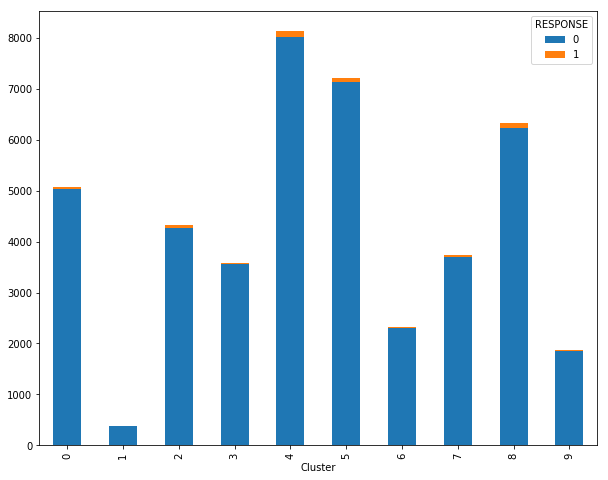

In [70]:
%%time
with open('kmodel.pkl', 'rb') as f:
    kmodel = pickle.load(f)

mailout_train_LNR_RESPONSE['Cluster'] = kmodel.predict(mailout_train_clean)
mailout_train_LNR_RESPONSE.groupby(['Cluster', 'RESPONSE'])['RESPONSE'].count().unstack('RESPONSE').plot(kind='bar', stacked=True)


## Response: 1 | Cluster Distribution

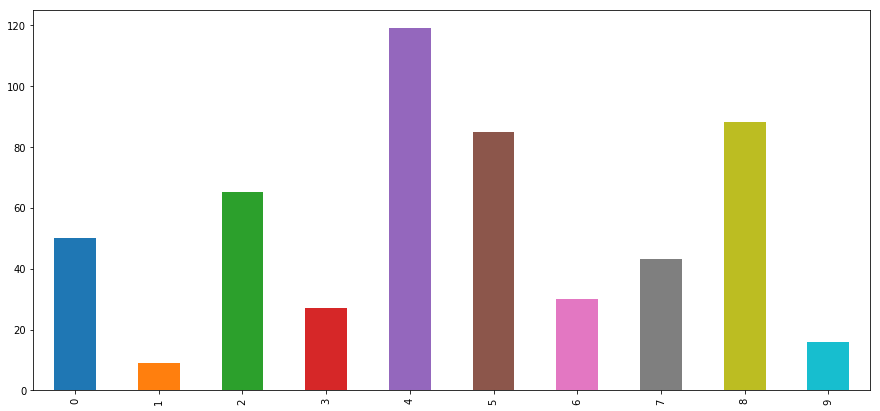

In [113]:
response_1 = mailout_train_LNR_RESPONSE[mailout_train_LNR_RESPONSE['RESPONSE']==1]['Cluster'].value_counts()
response_1.reindex([0,1,2,3,4,5,6,7,8,9]).plot(kind='bar')

## Response: 0 | Cluster Distribution

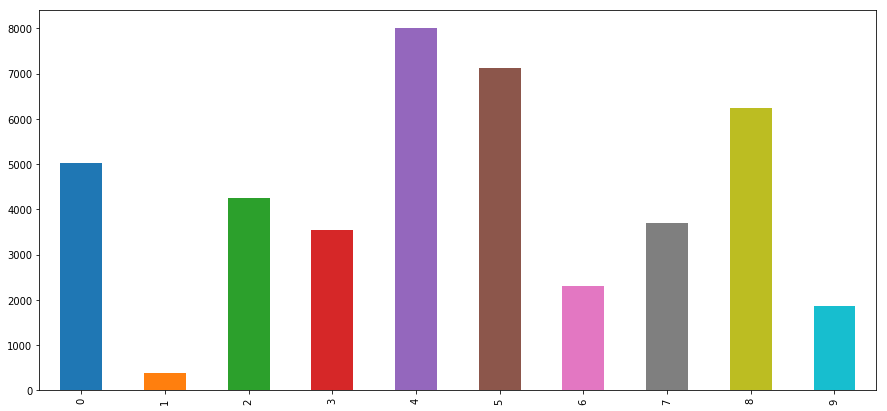

In [114]:
response_2 = mailout_train_LNR_RESPONSE[mailout_train_LNR_RESPONSE['RESPONSE']==0]['Cluster'].value_counts()
response_2.reindex([0,1,2,3,4,5,6,7,8,9]).plot(kind='bar')

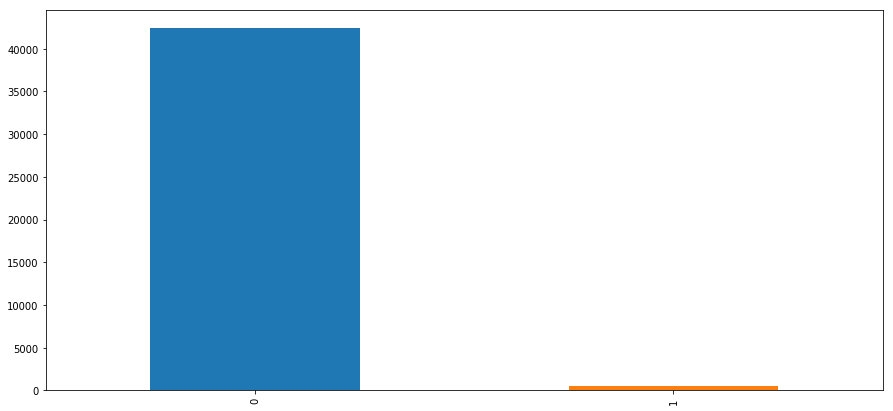

In [110]:
mailout_train_LNR_RESPONSE['RESPONSE'].value_counts().plot(kind='bar')

## Creating Model

In [67]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor # Adaptive Boosting
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold

In [15]:
def investigate_models(list_of_models,models_names,X,y):
    
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    skf.get_n_splits(X, y)
    model_scores = {}

    for i, clf in enumerate(list_of_models):
        print("_____________________________________")
        print(f"Classifier {i+1}: {models_names[i]}")
        scores = []
        j = 0

        # Perform 5-fold validation
        for train_index, test_index in skf.split(X, y):
            j+=1
            print('Classifier {}: Fold {}...'.format(i+1, j))

            # Split the data into training and test sets
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train using the pipeline
            clf.fit(X_train, y_train)

            #Predict on the test data
            
            y_pred = clf.predict_proba(X_test)[:, 1]

            score = roc_auc_score(y_test, y_pred)
            scores.append(score)
            print(score)

        model_scores[clf] = scores

    scores_df = pd.DataFrame(model_scores)
    scores_df.columns = models_names
    return scores_df

In [71]:
X = mailout_train_clean
y = mailout_train_LNR_RESPONSE['RESPONSE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Using SMOTE for oversampling

In [72]:
%%time
clusters=mailout_train_LNR_RESPONSE['RESPONSE']
with active_session():
    over = SMOTE(sampling_strategy=0.1)

    new_X = pd.DataFrame(columns=selected_columns)
    new_y = pd.DataFrame()
    clusters = mailout_train_LNR_RESPONSE
    X_list = []
    y_list = []

    for k in clusters['Cluster'].sort_values().unique():
        indexes = clusters[clusters['Cluster']==k].index
        X_cluster = X.iloc[indexes]
        y_cluster = y.iloc[indexes]
        X_resample, y_resample = over.fit_resample(X_cluster, y_cluster)
        X_list.append(X_resample)
        y_list.append(y_resample)
        print(f"Cluster {k}: OK!")
    new_X = pd.concat(X_list, ignore_index=True)
    new_y = pd.concat(y_list, ignore_index=True)

Cluster 0: OK!
Cluster 1: OK!
Cluster 2: OK!
Cluster 3: OK!
Cluster 4: OK!
Cluster 5: OK!
Cluster 6: OK!
Cluster 7: OK!
Cluster 8: OK!
Cluster 9: OK!
CPU times: user 1.11 s, sys: 71.8 ms, total: 1.18 s
Wall time: 1.28 s


In [73]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.40, random_state=42)

In [27]:
%%time
models = [AdaBoostClassifier(n_estimators=100),RandomForestClassifier(random_state=42),GradientBoostingClassifier()]
models_names = ['AdaBoostClassifier', 'RandomForestClassifier', 'GradientBoostingClassifier']

with active_session():
    score_df = investigate_models(models,models_names,X_train,y_train)

_____________________________________
Classifier 1: AdaBoostClassifier
Classifier 1: Fold 1...
0.943583126596581
Classifier 1: Fold 2...
0.9243878877849283
Classifier 1: Fold 3...
0.9356574308040941
Classifier 1: Fold 4...
0.9329081601316824
Classifier 1: Fold 5...
0.9099349495749804
_____________________________________
Classifier 2: RandomForestClassifier
Classifier 2: Fold 1...
0.9763519892783455
Classifier 2: Fold 2...
0.9646130901208488
Classifier 2: Fold 3...
0.9755748844732067
Classifier 2: Fold 4...
0.971711164750393
Classifier 2: Fold 5...
0.9584803551248036
_____________________________________
Classifier 3: GradientBoostingClassifier
Classifier 3: Fold 1...
0.9538695593436823
Classifier 3: Fold 2...
0.9353586242999608
Classifier 3: Fold 3...
0.9517704238334552
Classifier 3: Fold 4...
0.9519795351808176
Classifier 3: Fold 5...
0.9285558544614779
CPU times: user 5min 52s, sys: 435 ms, total: 5min 52s
Wall time: 5min 54s


In [28]:
score_df

,AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
0,0.943583,0.976352,0.953870
1,0.924388,0.964613,0.935359
2,0.935657,0.975575,0.951770
3,0.932908,0.971711,0.951980
4,0.909935,0.958480,0.928556


In [30]:
score_df.mean()

AdaBoostClassifier            0.929294
RandomForestClassifier        0.969346
GradientBoostingClassifier    0.944307
dtype: float64

In [19]:
%%time
with active_session():
    param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': ['sqrt'],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [10, 12,15],
    'n_estimators': [100,200]
    }
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid,cv = 2, n_jobs = -1, verbose = 2)
    grid_search.fit(X_train,y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  47.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  47.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=1000; total time=  47.0s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=1000; total time=  47.5s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=1000; total time=  47.2s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=1000; total time=  48.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimator

In [23]:
best_params_rf = grid_search.best_params_
best_params_rf

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 1000}

## Classifiers & Regressors Models

## Default Data

In [74]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.60, random_state=42)

In [75]:
%%time
rf = RandomForestClassifier(n_estimators=1000, random_state=42, max_features=None)
try:
    with open('rf_model.pkl', 'rb') as f:
        rf = pickle.load(f)
        print("Model Loaded")
except:
    with active_session():
        rf.fit(X_train,y_train)
        with open('rf_model.pkl', 'wb') as f:
            pickle.dump(rf, f)
        print("Model Created and Saved")

Model Loaded
CPU times: user 112 ms, sys: 79.1 ms, total: 191 ms
Wall time: 320 ms


In [76]:
%%time
rf_2 = RandomForestClassifier(n_estimators=1000, random_state=42, max_features=None,criterion='entropy',min_samples_leaf=10)
try:
    with open('rf_model_2.pkl', 'rb') as f:
        rf_2 = pickle.load(f)
        print("Model Loaded")
except:
    with active_session():
        rf_2.fit(X_train,y_train)
        with open('rf_model_2.pkl', 'wb') as f:
            pickle.dump(rf_2, f)
        print("Model Created and Saved")

Model Loaded
CPU times: user 90.2 ms, sys: 24.3 ms, total: 115 ms
Wall time: 163 ms


In [77]:
%%time
rf_3 = RandomForestClassifier(n_estimators=1000, random_state=42, max_features=None,criterion='entropy')
try:
    with open('rf_model_3.pkl', 'rb') as f:
        rf_3 = pickle.load(f)
        print("Model Loaded")
except:
    with active_session():
        rf_3.fit(X_train,y_train)
        with open('rf_model_3.pkl', 'wb') as f:
            pickle.dump(rf_3, f)
        print("Model Created and Saved")

Model Loaded
CPU times: user 103 ms, sys: 73.3 ms, total: 176 ms
Wall time: 274 ms


In [78]:
roc1 = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
roc2 = roc_auc_score(y_test, rf_2.predict_proba(X_test)[:, 1])
roc3 = roc_auc_score(y_test, rf_3.predict_proba(X_test)[:, 1])

In [79]:
print(f" Model 1: {roc1}\n Model 2: {roc2}\n Model 3: {roc3}")

 Model 1: 0.9791896329459004
 Model 2: 0.9643743252278538
 Model 3: 0.9685670581178392


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [50]:
%%time
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

CPU times: user 1.65 s, sys: 132 ms, total: 1.78 s
Wall time: 2.06 s


<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


In [80]:
%%time
with active_session():
    
    with open('selected_columns.pkl', 'rb') as f:
        selected_columns = pickle.load(f)
        
        
    mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
    print(f"Dataset Loaded")
    mailout_test_LNR = mailout_test['LNR'].copy()
    mailout_test_clean = mailout_test.copy()
    mailout_test_clean = data_full_adjustment(mailout_test_clean)
    
    print("Filling NaNs:")
    mailout_test_clean = fill_nans_kmeans(mailout_test_clean)

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


Dataset Loaded
Fixed Warning Columns
Setting only common attributes: OK!
Standardize Dataset Values: OK!
Wealth Feature, ok!
Family Feature, ok!
Neighborhood Feature, ok!
Community Feature, ok!
Gender Feature, ok!
Life Stage Feature, ok!
Income Feature, ok!
Positioning(Mainstream vs Avantgarde) Feature, ok!
Fixing birthdate attribute - replacing zeros to NaNs
Feature Engeneering: OK!
Filling NaNs:
Cluster nº0 - OK
Cluster nº1 - OK
Cluster nº2 - OK
Cluster nº3 - OK
Cluster nº4 - OK
Cluster nº5 - OK
Cluster nº6 - OK
Cluster nº7 - OK
Cluster nº8 - OK
Cluster nº9 - OK
Cluster nº10 - OK
Cluster nº11 - OK
Cluster nº12 - OK
Cluster nº13 - OK
Cluster nº14 - OK
Cluster nº15 - OK
Cluster nº16 - OK
Cluster nº17 - OK
Cluster nº18 - OK
Cluster nº19 - OK
Cluster nº20 - OK
Cluster nº21 - OK
Cluster nº22 - OK
Cluster nº23 - OK
Cluster nº24 - OK
Cluster nº25 - OK
Cluster nº26 - OK
Cluster nº27 - OK
Cluster nº28 - OK
Cluster nº29 - OK
Cluster nº30 - OK
Cluster nº31 - OK
Cluster nº32 - OK
Cluster nº33 - 

In [81]:
%%time
with active_session():
    X_mail_test = mailout_test_clean

CPU times: user 7.26 ms, sys: 357 µs, total: 7.61 ms
Wall time: 46.3 ms


In [82]:
mailout_test_LNR = pd.DataFrame(mailout_test_LNR, columns=['LNR'])

In [85]:
mailout_test_LNR['RESPONSE'] = rf.predict_proba(X_mail_test)[:,1]

In [88]:
mailout_test_LNR[['LNR','RESPONSE']]

,LNR,RESPONSE
0,1754,0.012000
1,1770,0.026000
2,1465,0.020000
3,1470,0.028000
4,1478,0.048000
5,1782,0.006000
6,1485,0.087000
7,1519,0.008000
8,1835,0.018000
9,1522,0.013000


In [91]:
submission = pd.DataFrame(index=mailout_test_LNR['LNR'].astype('int32'), data=rf.predict_proba(X_mail_test)[:,1], columns=['RESPONSE'])

In [92]:
submission

,RESPONSE
LNR,
1754,0.012000
1770,0.026000
1465,0.020000
1470,0.028000
1478,0.048000
1782,0.006000
1485,0.087000
1519,0.008000
1835,0.018000


In [93]:
submission.to_csv('submission.csv')